# Credit scoring task

features:
* client_id - идентификатор клиента
* education - уровень образования
* sex - пол заемщика
* age - возраст заемщика
* car - флаг наличия автомобиля
* car_type - флаг автомобиля иномарки
* decline_app_cnt - количество отказанных прошлых заявок
* good_work - флаг наличия “хорошей” работы
* bki_request_cnt - количество запросов в БКИ
* home_address - категоризатор домашнего адреса
* work_address - категоризатор рабочего адреса
* income - доход заемщика
* foreign_passport - наличие загранпаспорта
* sna - связь заемщика с клиентами банка
* first_time - давность наличия информации о заемщике
* score_bki - скоринговый балл по данным из БКИ
* region_rating - рейтинг региона
* app_date - дата подачи заявки
* default - флаг дефолта по кредиту [target binar]

# Import libraries

In [5]:
from pandas import Series 
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


from sklearn.metrics import confusion_matrix, auc, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import warnings
warnings.filterwarnings("ignore") 


# Def functions

In [6]:
def basic_info(train_df,test_df):
    print('info for TRAIN data:')
    display(train_df.describe())
    display(train_df.info())
    display(train_df.sample(2))
    display(train_df.isna().sum())
    print('info for TEST data:')
    display(test_df.describe())
    display(test_df.info())
    display(test_df.sample(2))
    display(test_df.isna().sum())

# Load data and set up settings

In [7]:
train = pd.read_csv('train.csv')
test= pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [8]:
# Lock a RANDOM SEED to keep it reproducible.
RANDOM_SEED = 420

In [9]:
# fix the version of the packages so that the experiments are reproducible:
!pip freeze > requirements.txt

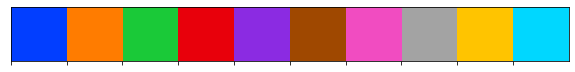

In [10]:
# choose colors
sequential_colors = sns.color_palette("bright", 10)
sns.set_palette(sequential_colors)
sns.palplot(sequential_colors)

# Explore data

In [11]:
basic_info(train,test)

info for TRAIN data:


,client_id,age,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,default
count,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000
mean,55137.965094,39.280641,0.275749,0.164894,-1.904724,2.000339,56.725701,1.575509,2.496280,41099.775417,1.733330,2.765458,0.126994
std,31841.921168,11.520378,0.804272,0.371087,0.498231,2.252073,13.055717,0.527631,0.689818,46166.322400,1.123622,1.009463,0.332968
min,1.000000,21.000000,0.000000,0.000000,-3.624586,0.000000,20.000000,1.000000,1.000000,1000.000000,1.000000,1.000000,0.000000
25%,27440.500000,30.000000,0.000000,0.000000,-2.259534,0.000000,50.000000,1.000000,2.000000,20000.000000,1.000000,2.000000,0.000000
50%,55274.000000,37.000000,0.000000,0.000000,-1.920823,1.000000,50.000000,2.000000,3.000000,30000.000000,1.000000,3.000000,0.000000
75%,82758.500000,48.000000,0.000000,0.000000,-1.569831,3.000000,60.000000,2.000000,3.000000,48000.000000,2.000000,4.000000,0.000000
max,110147.000000,72.000000,33.000000,1.000000,0.199773,53.000000,80.000000,3.000000,3.000000,1000000.000000,4.000000,4.000000,1.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

None

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
34589,67404,16MAR2014,SCH,M,44,N,N,0,0,-1.304592,3,70,1,2,50000,1,4,N,0
32501,77204,25MAR2014,SCH,F,52,Y,Y,0,0,-2.128333,0,80,2,3,17000,1,4,Y,0


client_id             0
app_date              0
education           307
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
default               0
dtype: int64

info for TEST data:


,client_id,age,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time
count,36349.000000,36349.000000,36349.000000,36349.000000,36349.000000,36349.000000,36349.000000,36349.000000,36349.000000,36349.000000,36349.000000,36349.000000
mean,54945.647473,39.186002,0.268040,0.166772,-1.904152,2.014471,56.802938,1.573798,2.501087,40835.755729,1.728053,2.765798
std,31706.052195,11.513258,0.788478,0.372777,0.501764,2.296789,13.086646,0.527428,0.683227,43802.180951,1.120686,1.011560
min,4.000000,21.000000,0.000000,0.000000,-3.574197,0.000000,20.000000,1.000000,1.000000,1000.000000,1.000000,1.000000
25%,27744.000000,30.000000,0.000000,0.000000,-2.261909,0.000000,50.000000,1.000000,2.000000,20000.000000,1.000000,2.000000
50%,54657.000000,37.000000,0.000000,0.000000,-1.920823,1.000000,50.000000,2.000000,3.000000,30000.000000,1.000000,3.000000
75%,82322.000000,48.000000,0.000000,0.000000,-1.563957,3.000000,60.000000,2.000000,3.000000,48000.000000,2.000000,4.000000
max,110148.000000,71.000000,30.000000,1.000000,0.188820,47.000000,80.000000,3.000000,3.000000,1000000.000000,4.000000,4.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         36349 non-null  int64  
 1   app_date          36349 non-null  object 
 2   education         36178 non-null  object 
 3   sex               36349 non-null  object 
 4   age               36349 non-null  int64  
 5   car               36349 non-null  object 
 6   car_type          36349 non-null  object 
 7   decline_app_cnt   36349 non-null  int64  
 8   good_work         36349 non-null  int64  
 9   score_bki         36349 non-null  float64
 10  bki_request_cnt   36349 non-null  int64  
 11  region_rating     36349 non-null  int64  
 12  home_address      36349 non-null  int64  
 13  work_address      36349 non-null  int64  
 14  income            36349 non-null  int64  
 15  sna               36349 non-null  int64  
 16  first_time        36349 non-null  int64 

None

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
13172,64462,13MAR2014,GRD,M,35,Y,Y,0,0,-1.489599,2,40,1,2,35000,1,4,N
31895,39412,15FEB2014,GRD,F,44,N,N,0,0,-1.386090,3,80,2,3,40000,1,3,Y


client_id             0
app_date              0
education           171
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
dtype: int64

In [12]:
sample_submission.shape

(24354, 2)

Features are same and total train test shape is 73798x36348 [test size~0.33]

# EDA

# 1. Get rid of Nans

In [13]:
display(train['education'].value_counts(dropna=False))
display(test['education'].value_counts(dropna=False))

SCH    38860
GRD    23365
UGR     9816
PGR     1257
NaN      307
ACD      194
Name: education, dtype: int64

SCH    19138
GRD    11403
UGR     4932
PGR      608
NaN      171
ACD       97
Name: education, dtype: int64

In [14]:
# fill missing values based on its probability
ed_vals = train['education'].value_counts().index.to_list()  # list of values
ed_probs = train['education'].value_counts(normalize=True).values  # list of probabilities
missings = train['education'].isnull()  # where are ours nans
train.loc[missings, ['education']] = np.random.choice(ed_vals, size=len(train[missings]), p=ed_probs) # fillna

I should also fill missings in test data. I must do it separetly from traing dataset as it may cause data leak.

In [15]:
# do same thing for test
ed_vals = test['education'].value_counts().index.to_list()  # list of values
ed_probs = test['education'].value_counts(normalize=True).values  # list of probabilities
missings = test['education'].isnull()  # where are ours nans
test.loc[missings, ['education']] = np.random.choice(ed_vals, size=len(test[missings]), p=ed_probs) # fillna

# 2. Data selection

In [16]:
train.columns

Index(['client_id', 'app_date', 'education', 'sex', 'age', 'car', 'car_type',
       'decline_app_cnt', 'good_work', 'score_bki', 'bki_request_cnt',
       'region_rating', 'home_address', 'work_address', 'income', 'sna',
       'first_time', 'foreign_passport', 'default'],
      dtype='object')

In [17]:
# divide data in 3 groups based on dtype
# we dont use user_id here
# we will use app_date further

# numerical 
num_cols = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income', 'score_bki', 'region_rating']

# categorical
cat_cols = ['education', 'work_address', 'home_address', 'sna', 'first_time']

# binary
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']

# 3. Numerical data explore

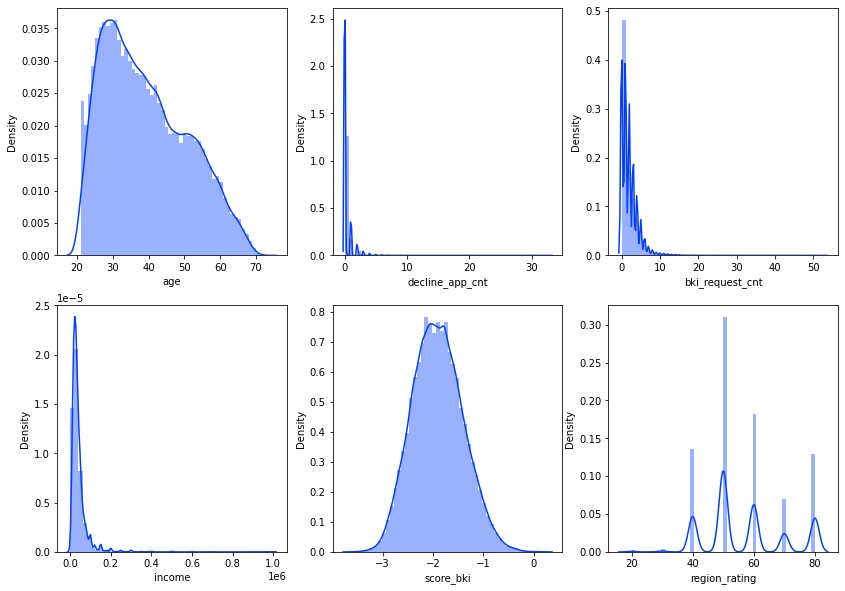

In [18]:
# take a look on dist of numerical data
a,b,c = 2,3,1 # c stands for counter and a&b for subplots params
fig = plt.figure(figsize=(14,10))
for col in num_cols:
    plt.subplot(a, b, c)
    plt.xlabel(col)
    sns.distplot(train[col])
    c = c + 1

plt.show()

We can see that:
* some of num features have strong right tail, we should take log func in future
* score_bki looks like it is already scaled

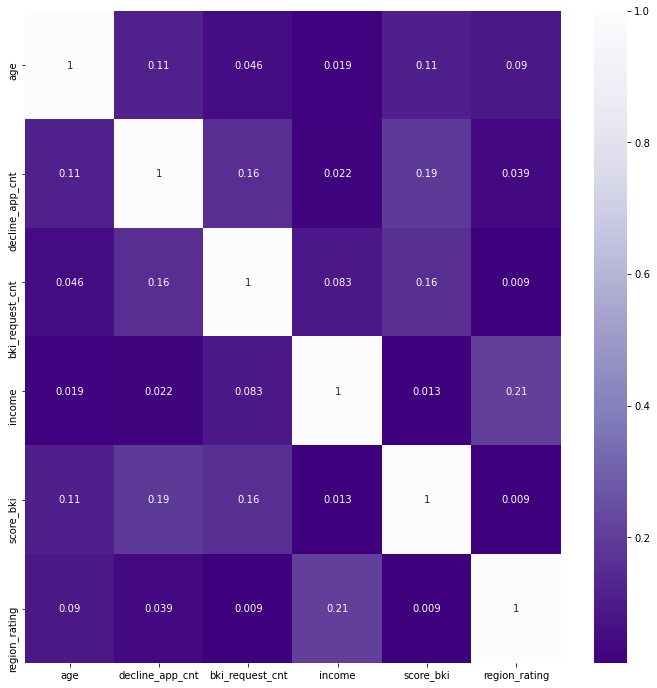

In [19]:
# check heatmap for too strong correlations as we building linear model
plt.figure(figsize=(12,12))
sns.heatmap(train[num_cols].corr().abs(),annot=True,cmap='Purples_r')
plt.show()

No too strong corr value

# 4. Binary and categorical data explore

In [20]:
# Using LabelEncoder to get rid of str dtype (for both dfs)

label_encoder = LabelEncoder()

for column in bin_cols:
    train[column] = label_encoder.fit_transform(train[column])
    
for column in bin_cols:
    test[column] = label_encoder.fit_transform(test[column])

In [21]:
# take a look
train.head(2)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,1,62,1,1,0,0,-2.008753,1,50,1,2,18000,4,1,0,0
1,63161,12MAR2014,SCH,0,59,0,0,0,0,-1.532276,3,50,2,3,19000,4,1,0,0


In [22]:
# format 'education' feature to int dtype
# treating education as ordinal dtype
train['education'] = train['education'].astype('category').cat.reorder_categories(['SCH','GRD','UGR','PGR','ACD']).cat.codes
test['education'] = test['education'].astype('category').cat.reorder_categories(['SCH','GRD','UGR','PGR','ACD']).cat.codes

In [23]:
# take a look
train.head(2)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,0,1,62,1,1,0,0,-2.008753,1,50,1,2,18000,4,1,0,0
1,63161,12MAR2014,0,0,59,0,0,0,0,-1.532276,3,50,2,3,19000,4,1,0,0


# 5. Datetime column 'app_date'

In [24]:
# convert to proper dtype
train['app_date'] = pd.to_datetime(train['app_date'])
test['app_date'] = pd.to_datetime(test['app_date'])

In [25]:
# explore year
display(train['app_date'].dt.year.value_counts())
display(test['app_date'].dt.year.value_counts())

2014    73799
Name: app_date, dtype: int64

2014    36349
Name: app_date, dtype: int64

In [26]:
# explore months
display(train['app_date'].dt.month.value_counts())
display(test['app_date'].dt.month.value_counts())

3    21178
2    18028
4    17683
1    16910
Name: app_date, dtype: int64

3    10419
2     9069
4     8583
1     8278
Name: app_date, dtype: int64

Data we have stands only for 2014 January February March April

# 6. Feature Eng

In [27]:
# add month col
train['month'] = train['app_date'].dt.month
test['month'] = train['app_date'].dt.month

# dont forget to update lists
cat_cols.append('month')

As i tried those - 'is_weekend' and 'day_of_week' - they dont have much sense 

In [28]:
train['decline_app_cnt'].value_counts()

0     61214
1      8397
2      2468
3       903
4       414
5       165
6       113
7        48
9        24
8        19
10       11
11        9
13        3
12        2
14        2
16        2
24        1
15        1
19        1
22        1
33        1
Name: decline_app_cnt, dtype: int64

In [29]:
# if its possible it could be good to convert numerical data to categorical
# hope it wont cause overfit
train['decline_app_cnt'] = train['decline_app_cnt'].apply(lambda x: x if x < 4 else 4)
test['decline_app_cnt'] = test['decline_app_cnt'].apply(lambda x: x if x < 4 else 4)

# lists update
num_cols.remove('decline_app_cnt')
cat_cols.append('decline_app_cnt')

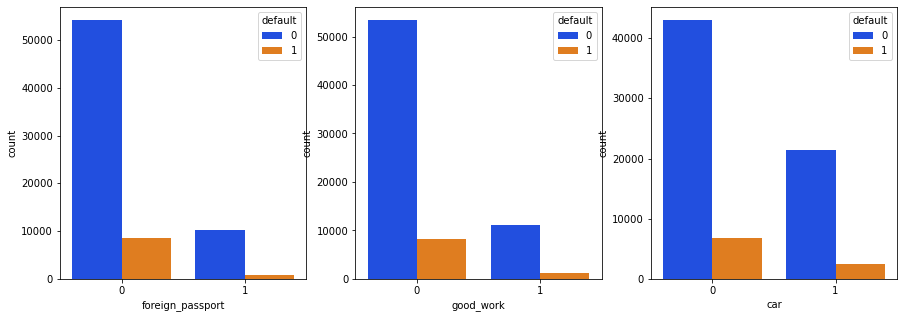

In [30]:
# we can help our model to identify decent customers by combining these features

signs_of_decency = ['foreign_passport','good_work','car']

a,b,c = 1,3,1
fig = plt.figure(figsize=(15,5))
for col in signs_of_decency:
    plt.subplot(a, b, c)
    plt.xlabel(col)
    sns.countplot(data=train,hue='default',x=col)
    c = c + 1

plt.show()

As vizualization says - those three have strong impact on target val, why not to combine them in some kind of polynomial feature

In [31]:
train['decent_customer_rate'] = (train['foreign_passport'] + 1) * (train['good_work'] + 1) * (train['car'] + 1)
test['decent_customer_rate'] = (test['foreign_passport'] + 1) * (test['good_work'] + 1) * (test['car'] + 1)

In [32]:
# update list
cat_cols.append('decent_customer_rate')

In [33]:
# take a look back on visualization of numerical data
# and log those wich are tailed

num_cols_tailed = ['age', 'bki_request_cnt', 'income']

for col in num_cols_tailed:
    train[col] = np.log(train[col] + 1)
    
    
for col in num_cols_tailed:
    test[col] = np.log(test[col] + 1)

# 7. Feature importance analysis

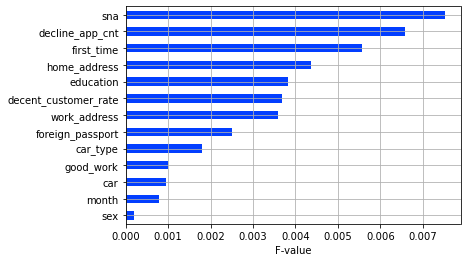

In [34]:
# plotting F - values fro categorical and binary dtypes
imp_cat = Series(mutual_info_classif(train[bin_cols + cat_cols], train['default'],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh',grid=True)
plt.xlabel('F-value')
plt.show()

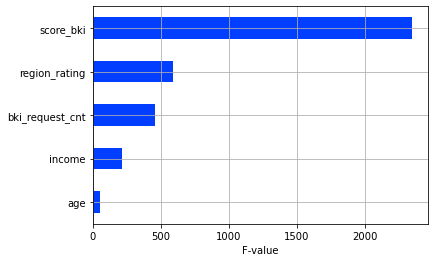

In [35]:
# same for numerical data
imp_num = Series(f_classif(train[num_cols], train['default'])[0],
                 index=num_cols)
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh',grid=True)
plt.xlabel('F-value')
plt.show()

In [36]:
train.head(2)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,month,decent_customer_rate
0,25905,2014-02-01,0,1,4.143135,1,1,0,0,-2.008753,...,50,1,2,9.798183,4,1,0,0,2,2
1,63161,2014-03-12,0,0,4.094345,0,0,0,0,-1.532276,...,50,2,3,9.852247,4,1,0,0,3,1


In [37]:
train.drop(['client_id', 'education'],axis = 1).corr()

,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,month,decent_customer_rate
sex,1.000000,-0.127008,0.279488,0.225578,0.022882,-0.040247,-0.045055,-0.047472,0.107711,0.037607,0.068967,0.305235,-0.003558,0.014126,0.086326,0.019619,-0.029600,0.172501
age,-0.127008,1.000000,-0.037130,-0.034069,-0.124736,-0.073322,-0.109971,0.049327,-0.090973,0.000180,-0.015311,-0.092586,-0.070400,0.095163,-0.037015,-0.026119,0.014924,-0.068995
car,0.279488,-0.037130,1.000000,0.697939,-0.036361,0.002027,-0.044782,-0.046411,0.064685,-0.025240,-0.007523,0.324723,-0.072100,0.089959,0.107568,-0.043161,-0.020234,0.599490
car_type,0.225578,-0.034069,0.697939,1.000000,-0.048438,0.017521,-0.040382,-0.016256,0.104110,-0.012032,0.000506,0.369633,-0.085844,0.103973,0.145807,-0.057484,-0.025034,0.483223
decline_app_cnt,0.022882,-0.124736,-0.036361,-0.048438,1.000000,-0.029736,0.202737,0.122564,-0.040175,0.011091,0.016592,-0.013102,0.069021,-0.073693,-0.029984,0.121318,-0.021818,-0.051268
good_work,-0.040247,-0.073322,0.002027,0.017521,-0.029736,1.000000,0.006269,0.006000,0.073041,-0.003624,-0.008535,0.051550,-0.054041,0.055821,0.046361,-0.043361,0.004882,0.522790
score_bki,-0.045055,-0.109971,-0.044782,-0.040382,0.202737,0.006269,1.000000,0.139622,0.008959,0.013847,0.012648,0.002860,0.067623,-0.069122,-0.021731,0.175369,-0.061736,-0.035764
bki_request_cnt,-0.047472,0.049327,-0.046411,-0.016256,0.122564,0.006000,0.139622,1.000000,-0.013354,0.003949,0.000348,0.081019,0.010048,0.010204,-0.003369,0.078501,-0.011060,-0.024259
region_rating,0.107711,-0.090973,0.064685,0.104110,-0.040175,0.073041,0.008959,-0.013354,1.000000,0.233820,0.253541,0.312551,-0.078199,0.088777,0.255456,-0.089035,0.004578,0.206594
home_address,0.037607,0.000180,-0.025240,-0.012032,0.011091,-0.003624,0.013847,0.003949,0.233820,1.000000,0.728139,0.046829,0.115196,-0.058476,0.038658,0.084637,0.168774,0.010798


<AxesSubplot:>

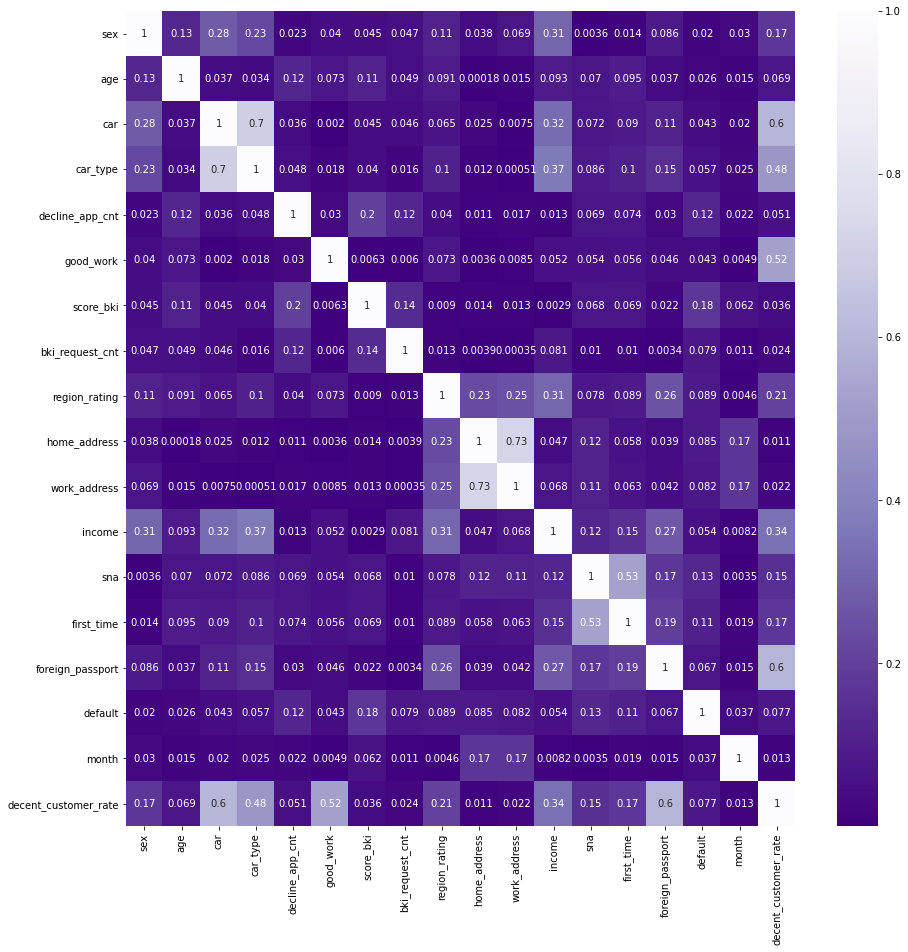

In [38]:
plt.figure(figsize=(15,15))
sns.heatmap(train.drop(['client_id', 'education'],axis = 1).corr().abs(),annot=True,cmap='Purples_r')

# 8. Build model

In [39]:
# dummy coding using OneHotEncoder fro categorical data
X_cat = OneHotEncoder(sparse = False).fit_transform(train[cat_cols].values)
X_cat

array([[1., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 1., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [40]:
Y_cat = OneHotEncoder(sparse = False).fit_transform(test[cat_cols].values)
Y_cat

array([[0., 1., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 1., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [41]:
# scale numerical train data

X_num = StandardScaler().fit_transform(train[num_cols].values)
X_num

array([[ 1.71113664, -0.28100505, -0.78501579, -0.2087987 , -0.51515718],
       [ 1.5399884 ,  0.77260728, -0.70752611,  0.74754461, -0.51515718],
       [-1.39343857, -0.28100505, -0.05288771,  0.99669566,  1.78270228],
       ...,
       [-0.66507223,  1.11179469,  0.5282444 ,  0.78696739,  1.78270228],
       [-0.89146325,  0.77260728, -1.25140899,  0.85380611, -0.51515718],
       [-0.35072683,  0.33531865, -0.31419734,  0.28102087, -0.51515718]])

In [42]:
# scale numerical test data

Y_num = StandardScaler().fit_transform(test[num_cols].values)
Y_num

array([[-0.88333898,  0.76643419,  0.68282058, -0.73288746, -0.51984533],
       [ 0.12606863,  0.33072139, -2.63253397,  0.79551047, -0.51984533],
       [ 0.97850869, -0.28338131, -0.05272498,  0.42413578, -0.51984533],
       ...,
       [-0.65688874, -0.28338131,  0.9453502 ,  1.92005304, -0.51984533],
       [-1.12541848,  0.33072139, -0.05272498,  1.31888606,  1.77259941],
       [ 0.0372345 ,  0.33072139, -1.05077617,  0.79042787, -0.51984533]])

In [43]:
# concat

X = np.hstack([X_num, train[bin_cols].values, X_cat])
Y = train['default'].values

id_test = test['client_id']
test = np.hstack([Y_num, test[bin_cols].values, Y_cat])

In [44]:
# we split train for a) train and b) valid
X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.2, random_state=42, shuffle = True)

In [45]:
# looking for best hyperparams

from sklearn.model_selection import GridSearchCV

# regularization
penalty = ['l1', 'l2']

# Зададим ограничения для параметра регуляризации
C = np.logspace(0, 4, 10)

# Создадим гиперпараметры
hyperparameters = dict(C=C, penalty=penalty)

model = LogisticRegression()
model.fit(X_train, y_train)

# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(X_train, y_train)

print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])

Лучшее Penalty: l2
Лучшее C: 166.81005372000593


In [46]:
# Описываем и обучаем модель
model = LogisticRegression( 
                           C=59.94842503189409, 
                           class_weight='balanced', 
                           dual=False, 
                           fit_intercept=True, 
                           intercept_scaling=1, 
                           l1_ratio=None, 
                           multi_class='auto', 
                           n_jobs=None, 
                           penalty='l2', 
                           solver='liblinear', 
                           verbose=0, 
                           max_iter=1000)

model.fit(X_train, y_train)

LogisticRegression(C=59.94842503189409, class_weight='balanced', max_iter=1000,
                   solver='liblinear')

In [47]:
# Предсказываем значения валидационной базы
Y_predict = model.predict(X_valid)
Y_predict_prob = model.predict_proba(X_valid)[:,1]

In [48]:
# Предсказываем значения тестовой базы
y_pred_test = model.predict(test)
y_pred_prob_test = model.predict_proba(test)[:,1]

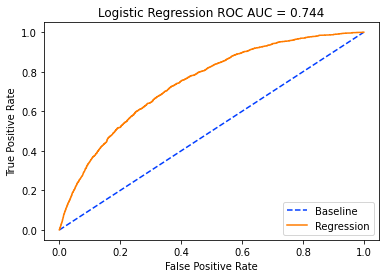

In [49]:
# Строим ROC-кривую
fpr, tpr, threshold = roc_curve(y_valid, Y_predict_prob)
roc_auc = roc_auc_score(y_valid, Y_predict_prob)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [50]:
# Обучаем модель на всей обучающей базе
main_model = LogisticRegression( 
                           C=59.94842503189409, 
                           class_weight='balanced', 
                           dual=False, 
                           fit_intercept=True, 
                           intercept_scaling=1, 
                           l1_ratio=None, 
                           multi_class='auto', 
                           n_jobs=None, 
                           penalty='l2', 
                           solver='liblinear', 
                           verbose=0, 
                           max_iter=1000)
main_model.fit(X, Y)

# Предсказываем значения тестовой базы
y_pred_test = main_model.predict(test)
y_pred_prob_test = main_model.predict_proba(test)[:,1]

In [51]:
# Записываем предсказанные моделью вероятности дефолта заемщиков из тестовой базы в отдельный файл
new_sample_submission = pd.DataFrame({'client_id': id_test,
                              'default': y_pred_prob_test})
new_sample_submission.to_csv('submission.csv', index=False)

new_sample_submission.head(10)

,client_id,default
0,74835,0.234250
1,17527,0.747823
2,75683,0.335464
3,26883,0.415402
4,28862,0.104880
5,99881,0.647835
6,26630,0.767563
7,79934,0.190209
8,16605,0.138897
9,105449,0.200859


In [52]:
new_sample_submission.shape

(36349, 2)